In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<Figure size 400x400 with 0 Axes>

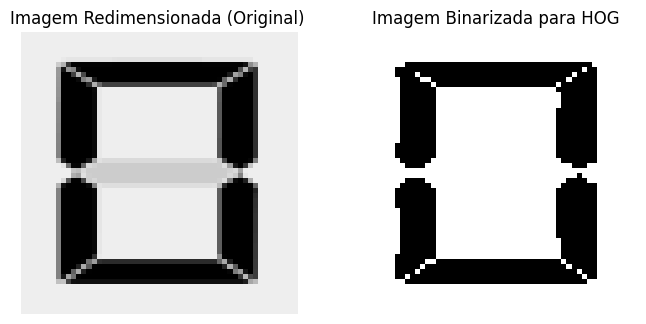

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Classe mais provável: 0
Probabilidade da classe mais provável: 71.66%
Probabilidades por classe:
Classe 0: 71.66%
Classe 1: 0.04%
Classe 2: 0.00%
Classe 3: 0.00%
Classe 4: 0.00%
Classe 5: 0.00%
Classe 6: 0.00%
Classe 7: 0.00%
Classe 8: 28.30%
Classe 9: 0.00%


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.filters import threshold_sauvola # Mantido para consistência com o artigo

# Função para preprocessar imagens para extração HOG (inferência)
def preprocess_image_for_hog_inference(image_path, target_size=(56, 56)):
    """
    Carrega e preprocessa uma imagem para extração HOG.

    Parâmetros:
        image_path (str): Caminho para a imagem.
        target_size (tuple): Dimensões para redimensionar as imagens (ex.: (56, 56)).

    Retorna:
        np.array: Imagem pré-processada (uint8) ou None se o carregamento falhar.
    """
    # Carrega a imagem em escala de cinza
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Verifica se a imagem foi carregada corretamente
    if img is None:
        print(f"Imagem não encontrada: {image_path}")
        return None

    # Redimensiona a imagem
    img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)

    # --- ETAPA DE BINARIZAÇÃO ---
    # O objetivo é ter segmentos ativos pretos (0) e fundo/segmentos inativos brancos (255).
    # A imagem 'zero.jpg' tem segmentos pretos (~0-50) e fundo/segmento central cinza (~180-200).

    # Opção 1: Binarização de Sauvola (preferencial, conforme o artigo)
    # Parâmetros podem precisar de ajuste. window_size deve ser ímpar.
    window_size = 15 # Menor para dígitos isolados
    k_sauvola = 0.2   # k pode variar; o artigo usa 0.34 para a tela inteira [cite: 199]
    try:
        thresh_s = threshold_sauvola(img_resized, window_size=window_size, k=k_sauvola)
        # Se os segmentos são mais escuros que o limiar, eles se tornam True (1). Multiplicamos por 255.
        # Para ter segmentos pretos, queremos que o que é MAIS ESCURO (menor valor) que o limiar seja 0.
        img_binarized = (img_resized < thresh_s).astype(np.uint8) * 255 # Segments escuros -> branco
        img_binarized = cv2.bitwise_not(img_binarized) # Inverte: Segments escuros -> preto, Fundo -> branco

    except ImportError:
        print("Scikit-image não encontrada para Sauvola. Usando Otsu como fallback.")
        # Opção 2: Binarização de Otsu (fallback se Sauvola não estiver disponível/falhar)
        # Otsu funciona bem para imagens bimodais (ex: objeto escuro, fundo claro).
        _, img_binarized = cv2.threshold(img_resized, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        # THRESH_BINARY + OTSU geralmente torna objetos mais escuros que o limiar em 'maxval' (255, branco).
        # Como queremos segmentos pretos, invertemos.
        img_binarized = cv2.bitwise_not(img_binarized)

    except Exception as e:
        print(f"Erro na binarização de Sauvola: {e}. Usando Otsu como fallback.")
        _, img_binarized = cv2.threshold(img_resized, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        img_binarized = cv2.bitwise_not(img_binarized)


    img_processed = img_binarized.astype(np.uint8)
    #--------------------------------

    # **Exibe a imagem que será usada para HOG no Colab**
    plt.figure(figsize=(4, 4))
    # A imagem original é img_resized, a processada é img_processed
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(img_resized, cmap="gray")
    ax[0].set_title("Imagem Redimensionada (Original)")
    ax[0].axis("off")

    ax[1].imshow(img_processed, cmap="gray")
    ax[1].set_title("Imagem Binarizada para HOG")
    ax[1].axis("off")
    plt.show()

    return img_processed

# O restante do seu código de inferência (extract_single_hog_feature, predict_class_with_hog)
# permanece o MESMO, pois ele espera uma imagem uint8 56x56 como entrada para HOG.

# Função para extrair características HOG de uma única imagem (sem alterações)
def extract_single_hog_feature(image_array_uint8):
    if image_array_uint8 is None:
        return None
    winSize = (56, 56)
    blockSize = (16, 16)
    blockStride = (8, 8)
    cellSize = (8, 8)
    nbins = 9
    hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)
    features = hog.compute(image_array_uint8)
    return features.flatten()

# Função de predição (sem alterações internas, mas agora usa a preprocess_image_for_hog_inference atualizada)
def predict_class_with_hog(model_path, image_path):
    try:
        model = tf.keras.models.load_model(model_path)
    except Exception as e:
        print(f"Erro ao carregar o modelo: {e}")
        return None, None, None

    img_for_hog = preprocess_image_for_hog_inference(image_path) # Esta função foi atualizada
    if img_for_hog is None:
        return None, None, None

    hog_features = extract_single_hog_feature(img_for_hog)
    if hog_features is None:
        return None, None, None

    hog_features_batch = np.expand_dims(hog_features, axis=0)

    try:
        predictions = model.predict(hog_features_batch)[0]
    except Exception as e:
        print(f"Erro durante a predição: {e}")
        print(f"Shape do HOG features para predição: {hog_features_batch.shape}")
        print(f"Input esperado pelo modelo: {model.input_shape}")
        return None, None, None

    predicted_class = np.argmax(predictions)
    probability = predictions[predicted_class]
    return predicted_class, probability, predictions

# Caminho do modelo e da imagem de entrada
model_path = 
image_path = 

# Faz a predição
predicted_class, probability, predictions = predict_class_with_hog(model_path, image_path)

# Mostra a saída
if predicted_class is not None:
    print(f"Classe mais provável: {predicted_class}")
    print(f"Probabilidade da classe mais provável: {probability:.2%}")
    print("Probabilidades por classe:")
    for i, prob in enumerate(predictions):
        print(f"Classe {i}: {prob:.2%}")
else:
    print("Não foi possível realizar a predição.")